# Adaptive Filtering-Introduction

In [1]:
from __future__ import division, print_function

## Introduction
So far we have considered the problem of tracking objects that are well behaved in relation to our process model. For example, we can use a constant velocity filter to track an object moving in a straight line. So long as the object moves in a straight line at a reasonably constant speed, or varies its track and/or velocity very slowly this filter will perform very well. Suppose instead that we are trying to track a maneuvering target, such as a car along a road, an aircraft in flight, and so on. In these situations the filters perform quite poorly. Alternatively, consider a situation such as tracking a sailboat in the ocean. Even if we model the control inputs we have no way to model the wind or the ocean currents.

A first order approach to this problem is to make the process noise $\mathbf{Q}$ larger to account for the unpredictability of the system dynamics. While this can work in the sense of providing a non-diverging filter, the result is typically far from optimal. The larger $\mathbf{Q}$ results in the filter giving more emphasis to the noise in the measurements. We will see an example of this shortly.

In this chapter we will discuss the concept of an adaptive filter. The filter will adapt itself when it detects dynamics that the process model cannot account for. I will start with an example of the problem, and then discuss and implement various adaptive filters.

## Maneuvering Targets
We need a simulation of a maneuvering target. I will implement a simple 2D model with steering inputs. You provide a new speed and/or direction, and it will modify its state to match.

In [2]:
from math import sin, cos, radians

In [3]:
def angle_between(x, y):
    return min(y-x, y-x+360, y-x-360, key=abs)

In [4]:
class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0

Now let's implement a simulated sensor with noise.

In [5]:
from numpy.random import randn

In [6]:
class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), pos[1] + (randn() * self.std))

Now let's generate a track and plot it to test that everything is working. I'll put the data generation in a function so we can create paths of different lengths (why will be clear soon).

In [7]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [9]:
def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

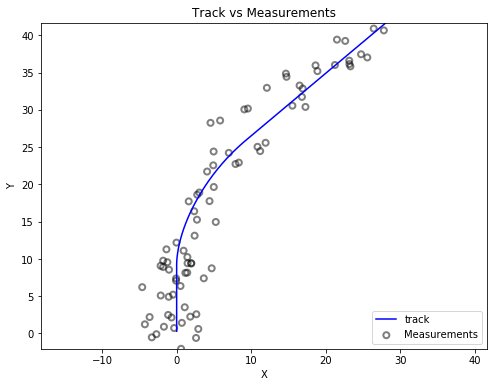

In [10]:
sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

Now we can implement a Kalman filter to track this object. But let's make a simplification. The x and y coordinates are independent, so we can track each independently. In the remainder of this chapter we will only track the x coordinate to keep the code and matrices as small as possible.

In [11]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [12]:
def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

In [13]:
def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

Now we run it:

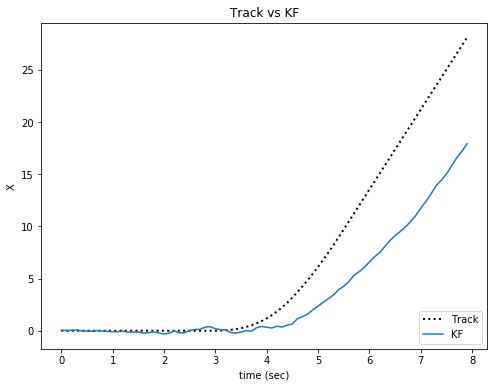

In [14]:
sensor_std = 2.
dt = 0.1

# initialize filter
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

# run it
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

# plot results
bp.plot_track(track[:, 0], dt=dt)
bp.plot_filter(kxs[:, 0], dt=dt, label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);

We can see from the plot that the Kalman filter was unable to track the change in heading. Recall from the g-h Filter chapter that this is because the filter is not modeling acceleration, hence it will always lag the input. 
The filter will eventually catch up with the signal if the signal enters a steady state. Let's look at that.

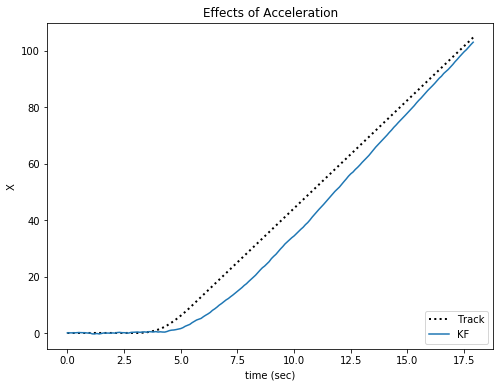

In [15]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)

track2, zs2 = generate_data(150, sensor_std)
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]

kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', 
              x='time (sec)', y='X')

The underlying problem is that our process model is correct for the steady state sections, but incorrect for when the object is maneuvering. We can try to account for this by increasing the size of Q, like so. (Q from 0.02 to 2.0)

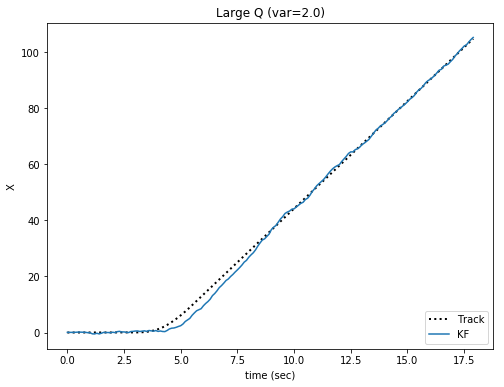

In [16]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=2.0)
track, zs = generate_data(50, sensor_std)

# recompute track
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Large Q (var=2.0)', x='time (sec)', y='X')

We can see that the filter reacquired the track more quickly, but at the cost of a lot of noise in the output. Furthermore, many tracking situations could not tolerate the amount of lag shown between seconds 4 and 8. We could reduce it further at the cost of very noisy output, like so (Q =50):

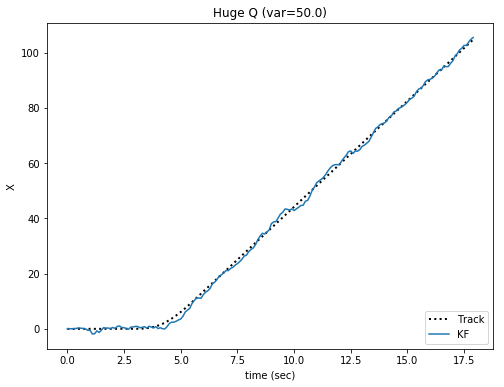

In [17]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=50.0)
track, zs = generate_data(50, sensor_std)

# recompute track
cvfilter.x.fill(0.)
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=50.0)', x='time (sec)', y='X')

Maneuvers imply acceleration, so let's implement a constant acceleration Kalman filter and see how it fairs with the same data.

In [18]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt],
                           [0, 1,         dt], 
                           [0, 0,          1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

In [19]:
def initialize_const_accel(f):
    f.x = np.array([0., 0., 0.])
    f.P = np.eye(3) * 3

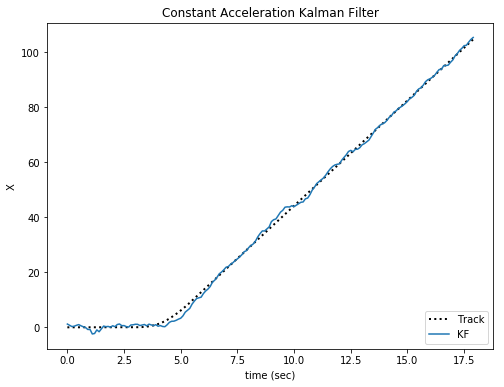

In [20]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceleration Kalman Filter', x='time (sec)', y='X')

The constant acceleration model is able to track the maneuver with no lag, but at the cost of very noisy output during the steady state behavior. The noisy output is due to the filter being unable to distinguish between the beginning of an maneuver and noise in the signal. Noise in the signal implies an acceleration, and so the acceleration term of the filter tracks it.

It seems we cannot win. A constant velocity filter cannot react quickly when the target is accelerating, but a constant acceleration filter misinterprets noise during zero acceleration regimes as acceleration instead of nosie.

Yet there is an important insight here that will lead us to a solution. When the target is not maneuvering (the acceleration is zero) the constant velocity filter performs optimally. When the target is maneuvering the constant acceleration filter performs well, as does the constant velocity filter with an artificially large process noise $\mathbf{Q}$. If we make a filter that adapts itself to the behavior of the tracked object we could have the best of both worlds.